## Tutorial 07 - Non linear Elliptic problem
**_Keywords: exact parametrized functions, POD-Galerkin_**

### 1. Introduction

In this tutorial, we consider a non linear elliptic problem in a two-dimensional spatial domain $\Omega=(0,1)^2$. We impose a homogeneous Dirichlet condition on the boundary $\partial\Omega$. The source term is characterized by the following expression
$$
g(\boldsymbol{x}; \boldsymbol{\mu}) = 100\sin(2\pi x_0)cos(2\pi x_1) \quad \forall \boldsymbol{x} = (x_0, x_1) \in \Omega.
$$

This problem is characterized by two parameters. The first parameter $\mu_0$ controls the strength of the sink term and the second parameter $\mu_1$ the strength of the nonlinearity. The range of the two parameters is the following:
$$
\mu_0,\mu_1\in[0.01,10.0]
$$
The parameter vector $\boldsymbol{\mu}$ is thus given by
$$
\boldsymbol{\mu} = (\mu_0,\mu_1)
$$
on the parameter domain
$$
\mathbb{P}=[0.01,10]^2.
$$


In order to be able to compare the interpolation methods (EIM and DEIM) used to solve this problem, we propose to use an exact solution of the problem.

### 2. Parametrized formulation

Let $u(\boldsymbol{\mu})$ be the solution in the domain $\Omega$.

The strong formulation of the parametrized problem is given by:
<center>for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})$ such that</center>

$$ -\nabla^2u(\boldsymbol{\mu})+\frac{\mu_0}{\mu_1}(\exp\{\mu_1u(\boldsymbol{\mu})\}-1)=g(\boldsymbol{x}; \boldsymbol{\mu})$$
<br>
    
The corresponding weak formulation reads:
<center>for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})\in\mathbb{V}$ such that</center>

$$a\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)+c\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V}$$

where

* the function space $\mathbb{V}$ is defined as
$$
\mathbb{V} = \{v\in H_1(\Omega) : v|_{\partial\Omega}=0\}
$$
* the parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$a(u, v;\boldsymbol{\mu})=\int_{\Omega} \nabla u\cdot \nabla v \ d\boldsymbol{x},$$
* the parametrized bilinear form $c(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$c(u, v;\boldsymbol{\mu})=\mu_0\int_{\Omega} \frac{1}{\mu_1}\big(\exp\{\mu_1u\} - 1\big)v \ d\boldsymbol{x},$$
* the parametrized linear form $f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is defined by
$$f(v; \boldsymbol{\mu})= \int_{\Omega}g(\boldsymbol{x}; \boldsymbol{\mu})v \ d\boldsymbol{x}.$$

The output of interest $s(\boldsymbol{\mu})$ is given by
$$s(\boldsymbol{\mu}) = \int_{\Omega} v \ d\boldsymbol{x}$$
is computed for each $\boldsymbol{\mu}$.

In [1]:
from dolfin import *
from rbnics import *

### 3. Affine Decomposition 

For this problem the affine decomposition is straightforward:
$$a(u,v;\boldsymbol{\mu})=\underbrace{1}_{\Theta^{a}_0(\boldsymbol{\mu})}\underbrace{\int_{\Omega}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_0(u,v)},$$
$$c(u,v;\boldsymbol{\mu})=\underbrace{\mu_0}_{\Theta^{c}_0(\boldsymbol{\mu})}\underbrace{\int_{\Omega}\frac{1}{\mu_1}\big(\exp\{\mu_1u\} - 1\big)v \ d\boldsymbol{x}}_{c_0(u,v)},$$
$$f(v; \boldsymbol{\mu}) = \underbrace{100}_{\Theta^{f}_0(\boldsymbol{\mu})} \underbrace{\int_{\Omega}\sin(2\pi x_0)cos(2\pi x_1)v \ d\boldsymbol{x}}_{f_0(v)}.$$
We will implement the numerical discretization of the problem in the class
```
class NonlinearElliptic(NonlinearEllipticProblem):
```
by specifying the coefficients $\Theta^{a}_*(\boldsymbol{\mu})$, $\Theta^{c}_*(\boldsymbol{\mu})$ and $\Theta^{f}_*(\boldsymbol{\mu})$ in the method
```
    def compute_theta(self, term):
```
and the bilinear forms $a_*(u, v)$, $c_*(u, v)$ and linear forms $f_*(v)$ in
```
    def assemble_operator(self, term):
```

In [2]:
@ExactParametrizedFunctions()
class NonlinearElliptic(NonlinearEllipticProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        NonlinearEllipticProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.du = TrialFunction(V)
        self.u = self._solution
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)
        # Store the forcing term expression
        self.f = Expression("sin(2*pi*x[0])*sin(2*pi*x[1])", element=self.V.ufl_element())
        # Customize nonlinear solver parameters
        self._nonlinear_solver_parameters.update({
            "linear_solver": "mumps",
            "maximum_iterations": 20,
            "report": True
        })

    # Return custom problem name
    def name(self):
        return "NonlinearEllipticExact"

    # Return theta multiplicative terms of the affine expansion of the problem.
    @compute_theta_for_derivatives
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = 1.
            return (theta_a0,)
        elif term == "c":
            theta_c0 = mu[0]
            return (theta_c0,)
        elif term == "f":
            theta_f0 = 100.
            return (theta_f0,)
        elif term == "s":
            theta_s0 = 1.0
            return (theta_s0,)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    @assemble_operator_for_derivatives
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            du = self.du
            a0 = inner(grad(du), grad(v)) * dx
            return (a0,)
        elif term == "c":
            u = self.u
            mu = self.mu
            c0 = (exp(mu[1] * u) - 1) / mu[1] * v * dx
            return (c0,)
        elif term == "f":
            f = self.f
            f0 = f * v * dx
            return (f0,)
        elif term == "s":
            s0 = v * dx
            return (s0,)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant(0.0), self.boundaries, 1)]
            return (bc0,)
        elif term == "inner_product":
            du = self.du
            x0 = inner(grad(du), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")


# Customize the resulting reduced problem
@CustomizeReducedProblemFor(NonlinearEllipticProblem)
def CustomizeReducedNonlinearElliptic(ReducedNonlinearElliptic_Base):
    class ReducedNonlinearElliptic(ReducedNonlinearElliptic_Base):
        def __init__(self, truth_problem, **kwargs):
            ReducedNonlinearElliptic_Base.__init__(self, truth_problem, **kwargs)
            self._nonlinear_solver_parameters.update({
                "report": True,
                "line_search": "wolfe"
            })

    return ReducedNonlinearElliptic

## 4. Main program

### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/square.xml")
subdomains = MeshFunction("size_t", mesh, "data/square_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/square_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P1)

In [4]:
V = FunctionSpace(mesh, "Lagrange", 1)

### 4.3. Allocate an object of the NonlinearElliptic class

In [5]:
problem = NonlinearElliptic(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(0.01, 10.0), (0.01, 10.0)]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a POD-Galerkin method

In [6]:
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(20)
reduction_method.set_tolerance(1e-8)

### 4.5. Perform the offline phase

In [7]:
reduction_method.initialize_training_set(50)
reduced_problem = reduction_method.offline()

=           NonlinearEllipticExact POD-Galerkin offline phase begins           =

###################################### 0 #######################################
truth solve for mu = (2.423502056963257, 4.76422755925246)
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 8.337733e-01
  2 SNES Function norm 2.342399e-01
  3 SNES Function norm 2.921155e-02
  4 SNES Function norm 5.301225e-04
  5 SNES Function norm 1.813152e-07
  6 SNES Function norm 2.182476e-14
PETSc SNES solver converged in 6 iterations with convergence reason 2.
update snapshots matrix

###################################### 1 #######################################
truth solve for mu = (9.304443918943951, 8.52257797034889)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 1.357975e+00
  2 SNES Function norm 1.218883e+00
  3 SNES Function norm 1.093374e+00
  4 SNES Funct

truth solve for mu = (8.36461348644402, 5.777973966655395)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 1.358854e+00
  2 SNES Function norm 1.115299e+00
  3 SNES Function norm 5.344952e-01
  4 SNES Function norm 5.428154e-02
  5 SNES Function norm 1.850701e-03
  6 SNES Function norm 2.181797e-06
  7 SNES Function norm 2.925750e-12
PETSc SNES solver converged in 7 iterations with convergence reason 2.
update snapshots matrix

###################################### 17 ######################################
truth solve for mu = (3.9706274233509475, 3.103536052824947)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 2.821584e-01
  2 SNES Function norm 3.610212e-02
  3 SNES Function norm 6.155506e-04
  4 SNES Function norm 1.787454e-07
  5 SNES Function norm 1.574606e-14
PETSc SNES solver converged in 5 iterations with convergence reason 2.
update snapshots matrix

###################################### 18 ######################################
truth solve for mu = (

  1 SNES Function norm 1.307092e-02
  2 SNES Function norm 8.115858e-06
  3 SNES Function norm 4.071927e-12
PETSc SNES solver converged in 3 iterations with convergence reason 2.
update snapshots matrix

###################################### 33 ######################################
truth solve for mu = (4.422128153061801, 3.3381724059255227)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 3.780924e-01
  2 SNES Function norm 6.247036e-02
  3 SNES Function norm 1.936090e-03
  4 SNES Function norm 1.886495e-06
  5 SNES Function norm 1.805159e-12
PETSc SNES solver converged in 5 iterations with convergence reason 2.
update snapshots matrix

###################################### 34 ######################################
truth solve for mu = (1.5141455077489114, 1.460420453464088)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 2.554788e-02
  2 SNES Function norm 6.306560e-05
  3 SNES Function norm 4.415364e-10
PETSc SNES solver converged in 3 iterations with converg

  5 SNES Function norm 1.362399e-14
PETSc SNES solver converged in 5 iterations with convergence reason 2.
update snapshots matrix

###################################### 49 ######################################
truth solve for mu = (1.017177311671121, 0.926712081714268)
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 9.329868e-03
  2 SNES Function norm 2.574729e-06
  3 SNES Function norm 3.014771e-13
PETSc SNES solver converged in 3 iterations with convergence reason 2.
update snapshots matrix

################################# perform POD ##################################
lambda_0 = 1267.4180221893077
lambda_1 = 12.773845764952153
lambda_2 = 0.04431806390869026
lambda_3 = 0.025507290544479092
lambda_4 = 0.001509652370908362
lambda_5 = 0.00021034729231330314
lambda_6 = 3.558359483880179e-05

build reduced operators

=            NonlinearEllipticExact POD-Galerkin offline phase ends            =



### 4.6. Perform an online solve

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
0:  |F(x)| = 3.67834; step 0.337506; tol 0.39169
1:  |F(x)| = 2.32439; step 0.345307; tol 0.359381
2:  |F(x)| = 1.233; step 0.437663; tol 0.25325
3:  |F(x)| = 0.124812; step 1; tol 0.00922218
4:  |F(x)| = 0.00405161; step 1; tol 0.000948381
5:  |F(x)| = 4.70103e-06; step 1; tol 1.21164e-06
scipy solver converged in 7 iterations.


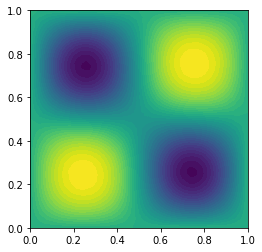

In [8]:
online_mu = (0.3, 9.0)
reduced_problem.set_mu(online_mu)
reduced_solution = reduced_problem.solve()
plot(reduced_solution, reduced_problem=reduced_problem)

### 4.7. Perform an error analysis

In [9]:
reduction_method.initialize_testing_set(50)
reduction_method.error_analysis()

=          NonlinearEllipticExact POD-Galerkin error analysis begins           =

###################################### 0 #######################################
0:  |F(x)| = 4.28684; step 0.225134; tol 0.54091
1:  |F(x)| = 3.4224; step 0.197301; tol 0.573625
2:  |F(x)| = 2.53163; step 0.247411; tol 0.492473
3:  |F(x)| = 1.44245; step 0.385318; tol 0.292173
4:  |F(x)| = 0.405435; step 1; tol 0.0711026
5:  |F(x)| = 0.0211189; step 1; tol 0.00244199
6:  |F(x)| = 6.26296e-05; step 1; tol 7.91513e-06
7:  |F(x)| = 5.53527e-10; step 1; tol 7.03009e-11
scipy solver converged in 9 iterations.
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 1.359057e+00
  2 SNES Function norm 1.221791e+00
  3 SNES Function norm 1.097711e+00
  4 SNES Function norm 9.360859e-01
  5 SNES Function norm 5.437671e-01
  6 SNES Function norm 1.113713e-01
  7 SNES Function norm 8.014307e-03
  8 SNES Function norm 4.586951e-05
  9 SNES Function norm 1.466439e-09
  10 SNES Function norm 4.177256e-15
PETSc SNES

scipy solver converged in 6 iterations.
###################################### 3 #######################################
0:  |F(x)| = 1.30361; step 1; tol 0.0500197
1:  |F(x)| = 0.155228; step 1; tol 0.0127612
2:  |F(x)| = 0.00252856; step 1; tol 0.000238808
3:  |F(x)| = 6.81078e-07; step 1; tol 6.52965e-08
scipy solver converged in 5 iterations.
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 1.174013e+00
  2 SNES Function norm 5.770563e-01
  3 SNES Function norm 8.551430e-02
  4 SNES Function norm 4.600979e-03
  5 SNES Function norm 1.391032e-05
  6 SNES Function norm 1.243785e-10
PETSc SNES solver converged in 6 iterations with convergence reason 2.
0:  |F(x)| = 3.05967; step 0.430379; tol 0.271022
1:  |F(x)| = 1.03027; step 1; tol 0.102046
2:  |F(x)| = 0.140752; step 1; tol 0.0167977
3:  |F(x)| = 0.00353004; step 1; tol 0.000566098
4:  |F(x)| = 2.3387e-06; step 1; tol 3.95034e-07
scipy solver converged in 6 iterations.
0:  |F(x)| = 3.06173; step 0.430064; tol 0.271387
1:

1:  |F(x)| = 2.88197; step 0.217514; tol 0.538773
2:  |F(x)| = 1.18335; step 1; tol 0.261249
3:  |F(x)| = 0.174946; step 1; tol 0.0196709
4:  |F(x)| = 0.00559489; step 1; tol 0.000920487
5:  |F(x)| = 6.25044e-06; step 1; tol 1.12326e-06
scipy solver converged in 7 iterations.
###################################### 6 #######################################
0:  |F(x)| = 4.04808; step 0.267569; tol 0.482333
1:  |F(x)| = 3.07621; step 0.235322; tol 0.51973
2:  |F(x)| = 2.16521; step 0.281474; tol 0.445873
3:  |F(x)| = 1.12865; step 0.42665; tol 0.244543
4:  |F(x)| = 0.26908; step 1; tol 0.0511553
5:  |F(x)| = 0.0109582; step 1; tol 0.00149265
6:  |F(x)| = 1.94066e-05; step 1; tol 2.82269e-06
7:  |F(x)| = 6.10407e-11; step 1; tol 8.90396e-12
scipy solver converged in 9 iterations.
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 1.359311e+00
  2 SNES Function norm 1.222607e+00
  3 SNES Function norm 1.099080e+00
  4 SNES Function norm 9.875066e-01
  5 SNES Function norm 8.706502e-

2:  |F(x)| = 0.363431; step 1; tol 0.065173
3:  |F(x)| = 0.0164649; step 1; tol 0.00184722
4:  |F(x)| = 3.68843e-05; step 1; tol 4.51653e-06
5:  |F(x)| = 1.85894e-10; step 1; tol 2.28608e-11
scipy solver converged in 7 iterations.
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 1.358722e+00
  2 SNES Function norm 1.220800e+00
  3 SNES Function norm 1.096119e+00
  4 SNES Function norm 9.244388e-01
  5 SNES Function norm 4.423244e-01
  6 SNES Function norm 3.675339e-02
  7 SNES Function norm 9.355649e-04
  8 SNES Function norm 6.103471e-07
  9 SNES Function norm 2.498164e-13
PETSc SNES solver converged in 9 iterations with convergence reason 2.
0:  |F(x)| = 3.73118; step 0.313427; tol 0.40304
1:  |F(x)| = 1.46934; step 0.545563; tol 0.146197
2:  |F(x)| = 0.0377249; step 1; tol 0.000593274
3:  |F(x)| = 0.000270105; step 1; tol 4.61374e-05
4:  |F(x)| = 1.41818e-08; step 1; tol 2.48108e-09
scipy solver converged in 6 iterations.
0:  |F(x)| = 3.73107; step 0.313445; tol 0.403016
1

4:  |F(x)| = 0.00634001; step 1; tol 0.00105519
5:  |F(x)| = 8.14402e-06; step 1; tol 1.48505e-06
6:  |F(x)| = 1.36049e-11; step 1; tol 2.51165e-12
scipy solver converged in 8 iterations.
###################################### 12 ######################################
0:  |F(x)| = 0.0574607; step 1; tol 9.71831e-05
1:  |F(x)| = 9.0902e-06; step 1; tol 2.25241e-08
2:  |F(x)| = 2.31265e-13; step 1; tol 5.82527e-16
scipy solver converged in 4 iterations.
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 8.657001e-02
  2 SNES Function norm 1.115772e-03
  3 SNES Function norm 2.564981e-07
  4 SNES Function norm 1.519665e-14
PETSc SNES solver converged in 4 iterations with convergence reason 2.
0:  |F(x)| = 0.406749; step 1; tol 0.00478971
1:  |F(x)| = 0.00513103; step 1; tol 0.000143218
2:  |F(x)| = 8.84306e-07; step 1; tol 2.67324e-08
scipy solver converged in 4 iterations.
0:  |F(x)| = 0.409629; step 1; tol 0.00485777
1:  |F(x)| = 0.00513412; step 1; tol 0.000141382
2:  |F(x)| = 

KeyboardInterrupt: 

### 4.8. Perform a speedup analysis

In [ ]:
reduction_method.speedup_analysis()